In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
import torch.nn as nn
from tqdm import tqdm
from google.colab import drive

drive.mount('/content/drive')

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cpu


In [ ]:
# Define your data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip()
])


batch_size = 2
classes = ('COVID19', 'Normal')

# Training, Val, Testing Folders
data_path = '/content/drive/MyDrive/Machine Learning/CovidDataset'


training_dir = f'{data_path}/train'
validation_dir = f'{data_path}/val'


# Apply Transform to the datasets
training_dataset = datasets.ImageFolder(training_dir, transform=transform)
validation_dataset = datasets.ImageFolder(validation_dir, transform=transform)

#Stratied Kfold Approach
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# store validation acc.
val_accuracies = []




for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(training_dataset)), training_dataset.targets)):


    train_data = torch.utils.data.Subset(training_dataset, train_idx)
    val_data = torch.utils.data.Subset(training_dataset, val_idx)


    # Dataloaders
    train_loader = DataLoader(train_data,batch_size=batch_size, shuffle= True, num_workers = 2)
    val_loader = DataLoader(val_data, batch_size = 2,shuffle= True, num_workers=1)



    # Load ResNet model
    resnet_model = models.resnet18(pretrained=True)
    num_classes = 2

    # Modify connected layer to match the number of classes in  dataset
    num_ftrs = resnet_model.fc.in_features
    classifier = nn.Sequential(
        nn.Linear(num_ftrs, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, num_classes)
    )
    resnet_model.fc = classifier


    resnet_model = resnet_model.to(device)

    # Define loss function and optimizer with weight decay
    optimizer = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
    criterion = nn.BCELoss()

    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        resnet_model.train()  #training mode
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            #outputs = resnet_model(inputs)
            one_hot_labels = torch.zeros(labels.size(0), num_classes)
            one_hot_labels.scatter_(1, labels.unsqueeze(1), 1)

            # forward + backward + optimize
            outputs = resnet_model(inputs)
            outputs = torch.sigmoid(outputs)

            #Cal loss
            loss = criterion(outputs, one_hot_labels)


            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Evaluate on val_loader
        resnet_model.eval()
        correct = 0
        val_loss = 0
        total = 0
        train_losses = []
        val_losses = []
        with torch.no_grad():
          for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

           #one hot encoder
            one_hot_labels = torch.zeros(labels.size(0), num_classes)
            one_hot_labels.scatter_(1, labels.unsqueeze(1), 1)

            # forward + backward + optimize
            outputs = resnet_model(inputs)
            outputs = torch.sigmoid(outputs)

            #Cal loss
            loss = criterion(outputs, one_hot_labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Cal the average validation loss
        avg_val_loss = val_loss / len(val_loader)

        # Append validation loss to the list
        val_losses.append(avg_val_loss)

        # Calculate validation accuracy
        fold_val_accuracy = 100 * correct / total
        val_accuracies.append(fold_val_accuracy)

        # Print training loss, validation loss, and validation accuracy
        print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader):.3f}, Validation Loss: {avg_val_loss:.3f}, Validation Accuracy: {fold_val_accuracy:.2f}%")
    print(f'Kfold{fold + 1 }: Completed')
print('Training Complete')




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 44.5MB/s]


Epoch 1, Training Loss: 0.697, Validation Loss: 0.659, Validation Accuracy: 50.00%
Epoch 2, Training Loss: 0.637, Validation Loss: 0.613, Validation Accuracy: 90.00%
Epoch 3, Training Loss: 0.629, Validation Loss: 0.523, Validation Accuracy: 100.00%
Epoch 4, Training Loss: 0.579, Validation Loss: 0.465, Validation Accuracy: 80.00%
Epoch 5, Training Loss: 0.530, Validation Loss: 0.418, Validation Accuracy: 80.00%
Kfold1: Completed
Epoch 1, Training Loss: 0.696, Validation Loss: 0.673, Validation Accuracy: 70.00%
Epoch 2, Training Loss: 0.675, Validation Loss: 0.646, Validation Accuracy: 80.00%
Epoch 3, Training Loss: 0.647, Validation Loss: 0.575, Validation Accuracy: 100.00%
Epoch 4, Training Loss: 0.619, Validation Loss: 0.499, Validation Accuracy: 100.00%
Epoch 5, Training Loss: 0.517, Validation Loss: 0.385, Validation Accuracy: 100.00%
Kfold2: Completed
Epoch 1, Training Loss: 0.715, Validation Loss: 0.641, Validation Accuracy: 90.00%
Epoch 2, Training Loss: 0.692, Validation Loss:

In [ ]:
#calculate average accuracy and loss
avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}%")

Average Validation Accuracy: 91.42%


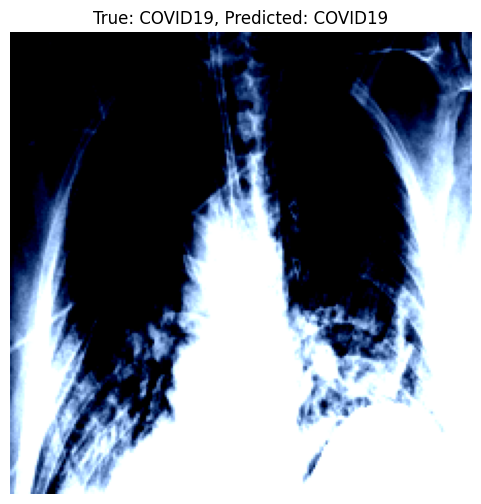

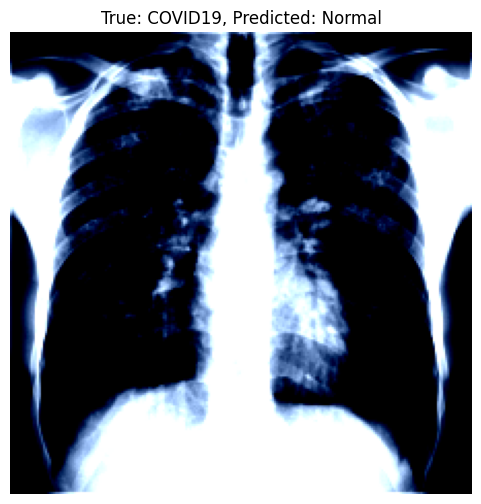

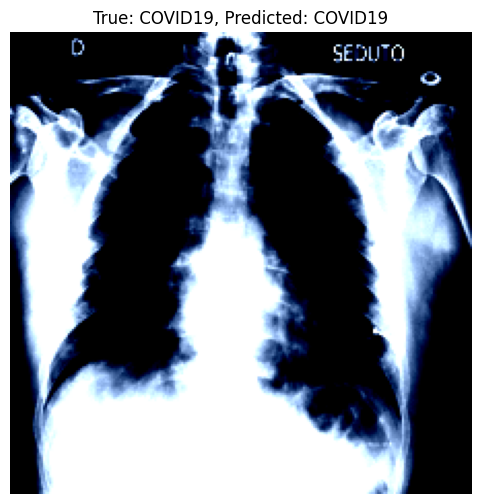

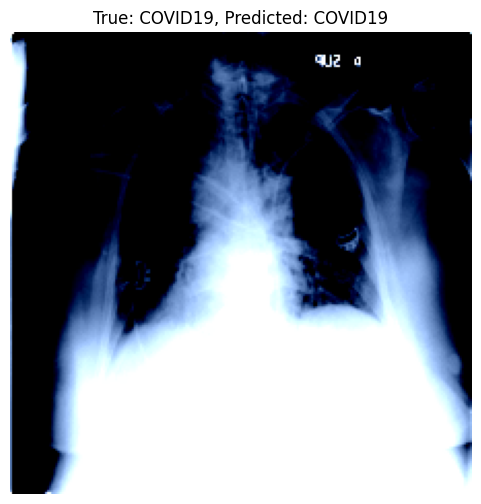

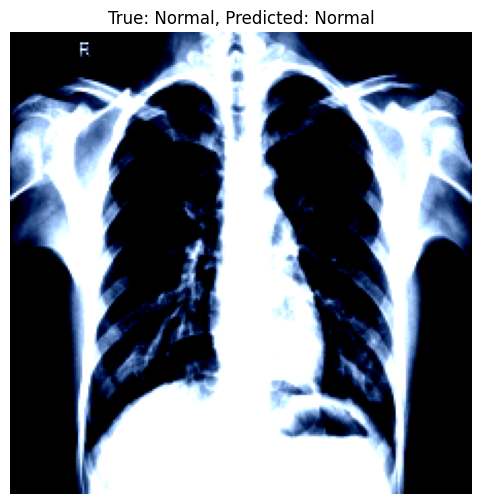

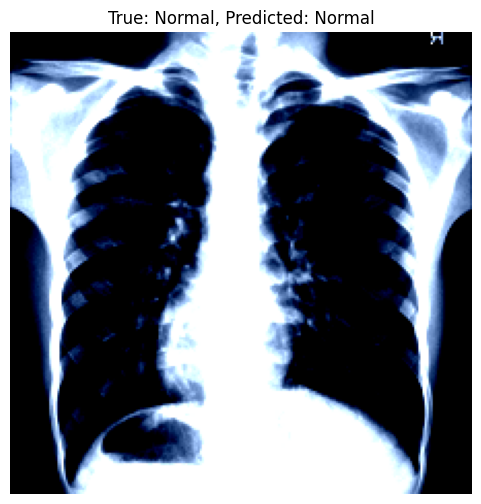

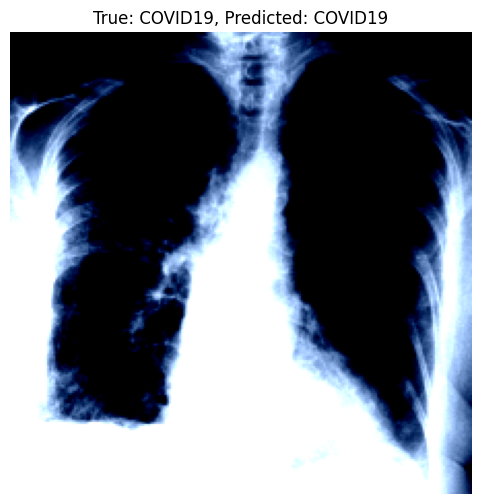

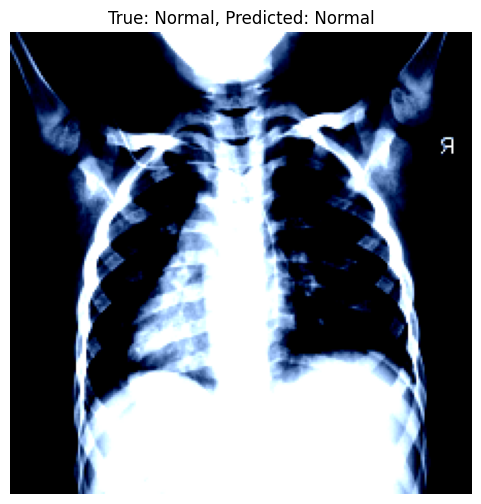

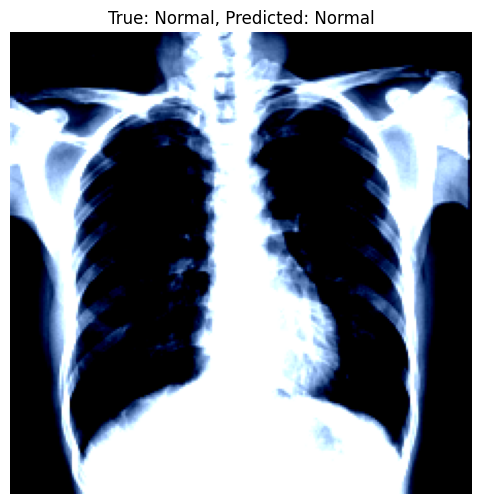

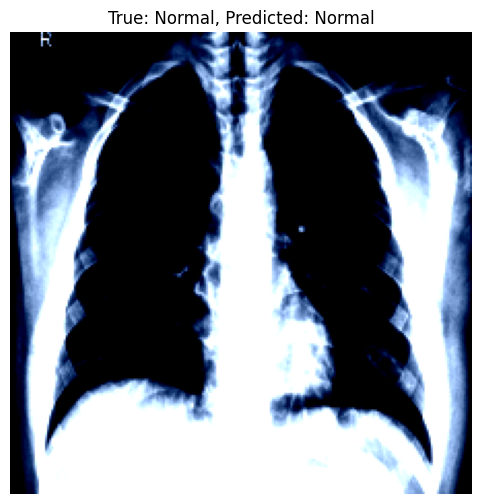

In [ ]:


# testing loop
test_loader = DataLoader(validation_dataset, batch_size = batch_size,shuffle=True, num_workers=1)
resnet_model.eval()  #evaluation mode
correct = 0
total = 0
y_true =[]
y_pred=[]

num_displayed = 0
num_images_to_display = 10
with torch.no_grad():
  for data in test_loader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = resnet_model(inputs)
      _, predicted = torch.max(outputs, 1)
      y_true.extend(labels)
      y_pred.extend(predicted)
      total += labels.size(0)
      correct += (predicted == labels).sum()

      class_idx_to_label = {0: 'COVID19', 1: 'Normal'}
      for i in range(len(inputs)):
        if num_displayed >= num_images_to_display:
            break

        predicted_label = class_idx_to_label[predicted[i].item()]
        true_label = class_idx_to_label[labels[i].item()]

        plt.figure(figsize=(6, 6))
        image = inputs[i].numpy().transpose((1, 2, 0))
        plt.imshow(image)
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

        num_displayed += 1






In [ ]:
#Test Accuracy
test_accuracy = 100 * correct / total
print(f"Overall Test Accuracy: {test_accuracy:.2f}%")

Overall Test Accuracy: 91.67%


In [ ]:
# Calculate confusion matrix and classification report
confusion = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Confusion Matrix:")
print(confusion)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Confusion Matrix:
[[5 1]
 [0 6]]
Accuracy: 0.92
Precision: 0.86
Recall: 1.00
F1 Score: 0.92


In [ ]:
%pip install pclpy



ERROR: Could not find a version that satisfies the requirement pclpy (from versions: none)
ERROR: No matching distribution found for pclpy
